In [1]:
import numpy as np
import scipy.stats as st
from multiprocessing import Pool
import time
import os
import matplotlib.pyplot as plt
from encoders import lt_enc, mds_enc, rep_enc
from time_analytics import lt_ana, mds_ana, rep_ana, get_worker_info
from decoders import lt_dec, mds_dec, rep_dec

In [2]:
def worker_mult(worker_args):
    
    #Each worker computes worker_mat.dot(vect)
    #Worker_rows contains the row indices of A_e sent to worker in worker_mat
    #Returns list of [time,index,value] lists corresponding to each row-vector product
    
    worker_rows = worker_args[0]
    worker_mat = worker_args[1]
    pid = os.getpid()
    np.random.seed(0)
    vect = np.random.randint(2, size = worker_mat.shape[1])
    sub_rows = worker_mat.shape[0]
    worker_results = []
    
    start_time = time.process_time()
    for row in range(sub_rows):
        val = worker_mat[row].dot(vect)
        ind = worker_rows[row]
        t = time.process_time()
        worker_results.append((t,ind,val))
        
    return pid, start_time, worker_results

In [ ]:
def one_comp(scheme_time, scheme_comp):
    
    scheme = 'one'
    
    for _ in range(num_iters):

        np.random.seed(0)
        vect = np.random.randint(2, size = num_cols)
        results = []
        
        start_time = time.process_time()
        for row in range(num_rows):
            val = A[row].dot(vect)
            ind = row
            t = time.process_time()
            results.append((t,ind,val))
        stop_time = results[-1][0] - start_time
    
    scheme_times[scheme].append(stop_time)
    scheme_comps[scheme].append(num_rows)

In [3]:
schemes_list = ['One','Unc','Rep','MDS','LT']

In [4]:
num_workers = 100 #Number of process
num_iters = 5 #Number of trials

In [ ]:
#Input matrix dimensions
num_rows = 10000 
num_cols = 10000

In [5]:
enc_params = {'Unc': 1, 'Rep': 2, 'MDS':int(num_workers/2), 'LT':2.0} #Encoder arguments (see encoders.py)
encoders = {'Unc': rep_enc, 'Rep': rep_enc, 'MDS':mds_enc, 'LT':lt_enc}
ana_params = {'Unc': 1, 'Rep': 2, 'MDS':int(num_workers/2), 'LT':11057} #Analyzer arguments (see time_analytics.py)
analyzers = {'Unc': rep_ana, 'Rep': rep_ana, 'MDS':mds_ana, 'LT':lt_ana}
decoders = {'Unc': rep_dec, 'Rep': rep_dec, 'MDS':mds_dec, 'LT':lt_dec}

In [6]:
A = np.random.randint(256,size=(num_rows,num_cols)) - 128 #Input matrix

In [7]:
#True Result
np.random.seed(0)
x = np.random.randint(2, size= num_cols)
b = A.dot(x)

In [ ]:
scheme_times = {'One': [], 'Unc': [], 'Rep': [], 'MDS':[], 'LT':[]}
scheme_comps = {'One': [], 'Unc': [], 'Rep': [], 'MDS':[], 'LT':[]}

In [8]:
for scheme in schemes_list:
    
    if scheme == 'One':
        one_comp(scheme_times, scheme_comps)
        continue
    
    print (scheme)
    
    #Generating Encoded Matrix and creating process pool
    A_e, encmat = encoders[scheme](A,num_workers,enc_params[scheme])
    worker_args_list = list(zip(np.split(np.arange(A_e.shape[0]),num_workers,0),np.split(A_e,num_workers,0)))
    pool = Pool(num_workers)
    
    for _ in range(num_iters):
        
        #Mapping tasks to workers and collecting results
        results = pool.map(worker_mult, worker_args_list)
        worker_dict = {}
        start_time = min([results[w][1] for w in range(num_workers)]) #Global start time
        
        for w in range(num_workers):
            worker_dict[w] = []
            for w_c in results[w][2]:
                t = w_c[0] - start_time
                ind = w_c[1]
                val = w_c[2]
                worker_dict[w].append((t,ind,val))
                
        #Processing results to generate decoder inputs and record latency and computations
        b_e, decmat, stop_time = analyzers[scheme](worker_dict,encmat,ana_params[scheme])
        scheme_times[scheme].append(stop_time)
        worker_times, worker_comps = get_worker_info(worker_dict,stop_time)
        scheme_comps[scheme].append(sum(worker_comps.values()))
        
        #Decoding matrix-vector product (b_d should be equal to b)
        b_d = decoders[scheme](b_e,decmat)
        if b_d is None:
            print ('Decoding Failed')
        else:
            print ('Decoding Error = '+str(np.sum((b-b_d)**2)))
    pool.close()

Unc
Decoding Error = 0.0
Decoding Error = 0.0
Decoding Error = 0.0
Decoding Error = 0.0
Decoding Error = 0.0
Rep
Decoding Error = 0.0
Decoding Error = 0.0
Decoding Error = 0.0
Decoding Error = 0.0
Decoding Error = 0.0
MDS
Decoding Error = 2.1593526955619886e-17
Decoding Error = 3.0702420982164017e-17
Decoding Error = 7.912778593094967e-16
Decoding Error = 2.0916163485195618e-17
Decoding Error = 2.6611760330830604e-16
LT
Decoding Error = 0.0
Decoding Error = 0.0
Decoding Error = 0.0
Decoding Error = 0.0
Decoding Error = 0.0


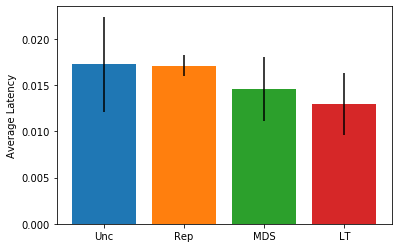

In [16]:
plt.figure()
for scheme in schemes_list:
    time_arr = np.array(scheme_times[scheme])
    time_avg = np.mean(time_arr)
    time_std = np.std(time_arr)
    plt.bar(scheme,time_avg,yerr=time_std)
plt.ylabel('Average Latency')
plt.show()

**LT-Coded computing has the lowest average latency**

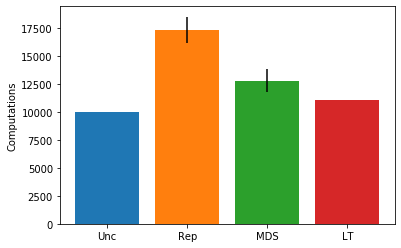

In [17]:
plt.figure()
for scheme in schemes_list:
    comp_arr = np.array(scheme_comps[scheme])
    comp_avg = np.mean(comp_arr)
    comp_std = np.std(comp_arr)
    plt.bar(scheme,comp_avg,yerr=comp_std)
plt.ylabel('Computations')
plt.show()

**LT-Coded computing performs the fewest extra average computations over uncoded**